# **Naive Bayes Classifier**

The goal is to create a Naive Bayes model (as well as a Multinomial Naive Bayes) that classifies a given YouTube comment as different sentiments like:
  - 'positive'
  - 'negative'
  - 'neutral'

**YouTube Comments Dataset**: https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset/data The dataset contains over 17,000 YouTube comments, each classified as either positive, negative, or neutral.`

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import calendar
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

### **Load the data**

In [ ]:
df = pd.read_csv('files/YoutubeCommentsDataSet.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [117]:
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


### **Explore the data**

Handle Missing Data

In [119]:
print('# missing values before:', df['Comment'].isnull().sum())

# Remove rows where comments are null
df = df.dropna(subset=['Comment'])

# Verify no Null comments in our data
print('# missing values after:', df['Comment'].isnull().sum())

# missing values before: 44
# missing values after: 0


Visualize the sentiment distribution

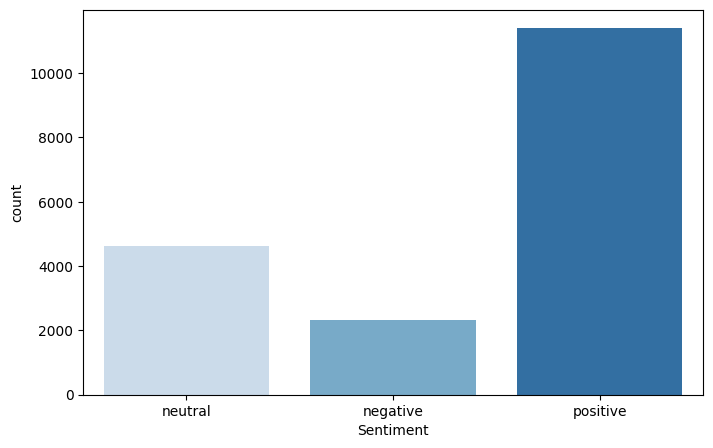

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Sentiment", hue="Sentiment", palette="Blues", legend=False);

Analyze comment lengths

In [ ]:
print(df['Comment'].loc[1])
print(len(df['Comment'].loc[1]))

here in nz 50 of retailers don’t even have contactless credit card machines like paywave which support apple pay they don’t like the high fees that come with these
163


In [122]:
# Get individual comment lengths
comment_lengths = df['Comment'].apply(len)

# Calculate average length in the comments
avg_comment_len = np.mean(comment_lengths)

print(f'Average Characters per Comment: {avg_comment_len:.2f}')

Average Characters per Comment: 177.55


Examine a sample comment

In [123]:
# Print comment and classificdation
print(df['Comment'].iloc[123])
print(df['Sentiment'].iloc[123])

i’m not a student however i always love seeing the tech always looking to change and upgrade my desk setup for work
positive


I think this comment should be classified as positive. I agree with the dataset's classification because the comment seems supportive of the YouTube video (which seems to be about one's desk setup and tech updrades) and is communicating that the video gave them inspiration for their desk setup.

I think is is entirely possible that some comments in the dataset are misclassified because internet lingo can vary quite differently among different demographics. There might be subtle nuances that make a seemingly positive or neutral comment more negative or mean. For example, there are lots of internet slangs that are quite negative but seem nonsensical to someone who doesn't use them. Sarcacsm can also be difficult to spot in an online text setting.

### **Preparing Text Data for Naïve Bayes Classification**

Separate the feature and target variables and then vectorize the text data.

In [ ]:
# Shape of DataFrame before vectorizing
df.shape

(18364, 2)

In [125]:
# Define the independent and target variables
X = df['Comment']
y = df['Sentiment']

In [ ]:
# Split the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Vectorize the data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) # transform only; already fitted to training data

In [ ]:
# Print the shapes of all resulting data structures
print('X_train_tfidf:', X_train_tfidf.shape)
print('X_test_tfidf:', X_test_tfidf.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train_tfidf: (13773, 1000)
X_test_tfidf: (4591, 1000)
y_train: (13773,)
y_test: (4591,)


Calculate the prior probabilities for each type of sentiment and populate a dictionary where:
- key = sentiment class
- value = prior probabilities

In [ ]:
# Get unique sentiment values as a df
unique_vals = df['Sentiment'].value_counts()

# Get total number of data points
total_vals = len(df)

# Calculate probabilities as a df
probabilities_df = unique_vals / total_vals

# Make dictionary of probabilities
dict_priors = probabilities_df.to_dict()
dict_priors

{'positive': 0.6208886952733609,
 'neutral': 0.2518514484861686,
 'negative': 0.12725985624047048}

### **Build a Naive Bayes Model (manual)**

In [130]:
def build_naive_bayes_model(X_train_tfidf, y_train, vectorizer):
    """
    Builds a Naive Bayes model dictionary for each target class in the dataframe.
    For each class, calculates the mean and standard deviation for every feature column,
    excluding the target column.

    Parameters:
    - X_train_tfidf: sparse matrix, TF-IDF transformed training data.
    - y_train: pandas Series, target sentiment labels.
    - vectorizer: TfidfVectorizer, used to extract feature names.

    Returns:
    - A dictionary where each key is a target class, and each value is another dictionary.
      This inner dictionary has feature column names as keys, and tuples of (mean, std deviation)
      as values for that feature with respect to the target class.
    """
    dict_nb_model = dict()

    # Get unique sentiment classes
    unique_targets = np.unique(y_train)

    # Convert TF-IDF sparse matrix to dense NumPy array
    tfidf_array = X_train_tfidf.toarray()

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Reset indices to align with tfidf_array
    y_train_reset = y_train.reset_index(drop=True)

    for target in unique_targets:
        # Get the indices of samples belonging to this class
        target_idxs = y_train_reset[y_train_reset == target].index

        # Extract the subset of the TF-IDF matrix for this class
        # Each row = one comment, each column = feature (n-gram)
        tfidf_subset = tfidf_array[target_idxs]

        # Create an empty dictionary for the target (we will put features in here)
        dict_nb_model[target] = {}

        # Iterate over feature indices instead of DataFrame columns
        for i, word in enumerate(feature_names):
            # Calculate mean and standard deviation, excluding NaN values
            mean = np.nanmean(tfidf_subset[:, i]) # average TF-IDF values for the ith feature
            stdev = np.nanstd(tfidf_subset[:, i]) # stdev of TF-IDF values for the ith feature
            dict_nb_model[target][word] = (mean, stdev)


    return dict_nb_model

In [131]:
dict_nb_model = build_naive_bayes_model(X_train_tfidf, y_train, vectorizer)

In [ ]:
# Use pretty print to display the model
from pprint import pprint
pprint(dict_nb_model)

{'negative': {'10': (0.0026529746295605194, 0.026021290942884932),
              '100': (0.0018376489912503564, 0.02102467510018126),
              '1010': (0.0, 0.0),
              '12': (0.0017771499315300254, 0.021857664080969556),
              '13': (0.0013083998229764502, 0.018719133899444292),
              '14': (0.0009665177618522828, 0.017937891546192106),
              '15': (0.0008299516217129385, 0.014937664084841025),
              '20': (0.0011984526846542474, 0.017342326065122593),
              '2022': (0.0005451838326316648, 0.012101446796887308),
              '2222': (0.0, 0.0),
              '2323': (0.0, 0.0),
              '25': (0.0010410067463706037, 0.018085337003539946),
              '30': (0.0014669982280715594, 0.02406454141732055),
              '50': (0.0013625629441401123, 0.02130070237288374),
              'able': (0.0025883587350642332, 0.02362344242140181),
              'about': (0.016235950983919896, 0.05395170077030909),
              'above': (0

### **Calculate the probability density of x for a Gaussian Distribution**

$p(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

In [ ]:
def get_probability(mu, sigma, x):
    """
    Calculate the probability density of x for a Gaussian distribution.

    This function computes the value of the probability density function (PDF)
    for a normal (Gaussian) distribution given the mean (mu), standard deviation
    (sigma), and a value x. The calculation is based on the formula for the PDF
    of a Gaussian distribution.

    Parameters:
    - mu (float): The mean of the Gaussian distribution.
    - sigma (float): The standard deviation of the Gaussian distribution. Sigma must be positive.
    - x (float): The point at which the PDF is evaluated.

    Returns:
    - float: The probability density of x in the Gaussian distribution defined by mu and sigma.

    Note:
    - The function assumes sigma > 0. Passing a non-positive sigma will result in a division by zero error.
    - This function does not check for the validity of the input types. Passing non-numeric types for mu, sigma, or x will result in a TypeError.
    """
    p = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * (((x - mu) / sigma) ** 2)
    return p * np.exp(exponent)


### **Naive Bayes classifier function**

In [134]:
import numpy as np

def nb_class(dict_priors, dict_nb_model, observation_tfidf):
    """
    Classifies a TF-IDF vector using the Naïve Bayes model.

    Parameters:
    - dict_priors (dict): Prior probabilities for each class.
    - dict_nb_model (dict): Gaussian distribution parameters (mean, std) for each TF-IDF feature.
    - observation_tfidf (numpy.ndarray): A single row from the TF-IDF matrix.

    Returns:
    - The class with the highest posterior probability.
    """
    dict_score = {}

    for target in dict_priors.keys():

        # Initialize score with log prior probability
        dict_score[target] = np.log(dict_priors[target])

        # Iterate over each TF-IDF feature
        for feature in range(len(observation_tfidf)):

            if feature in dict_nb_model[target]: # make sure feature exists for target

                # Get mean and standard deviation
                mu, sigma = dict_nb_model[target][feature]

                # Compute Gaussian probability
                gaussian_prob = get_probability(mu, sigma, x=observation_tfidf[feature])

                # Avoid zero probability issues by adding a small constant
                gaussian_prob += 1e-10

                # Use log probabilities to prevent underflow
                log_gaussian_prob = np.log(gaussian_prob)

                # Accumulate log probabilities
                dict_score[target] += log_gaussian_prob

    # Return the class with the highest posterior probability
    return max(dict_score, key=dict_score.get)

### **Determine accuracy of Naive Bayes classifier**

Preprocess the test set, then make predictions and calculate the accuracy as the mean of the correct predictions (compare the predictions list with the actual values in the 'Type' column of df_test).

In [135]:
predictions = []

# Convert sparse TF-IDF matrix to an array for iteration
X_test_array = X_test_tfidf.toarray()

# Loop through test dataset
for i in range(X_test_array.shape[0]):
    # Extract the TF-IDF vector for this sample
    tfidf_vector = X_test_array[i]

    # Predict sentiment using Naïve Bayes
    pred_sentiment = nb_class(dict_priors, dict_nb_model, tfidf_vector)

    # Add predicted sentiment to list
    predictions.append(pred_sentiment)

# Convert predictions list to a NumPy array
y_pred_array = np.array(predictions)

# Calculate accuracy
accuracy = np.mean(y_pred_array == y_test)

# Print final accuracy
print('Manual Accuracy is {:.2f}%'.format(accuracy * 100))

Manual Accuracy is 62.36%


### **Build a Naive Bayes model (sklearn)**

In [136]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def train_test_nb(X_train, X_test, y_train, y_test, model_nb):
    """
    Trains and tests a Naive Bayes model using scikit-learn on vectorized text data.
    Converts sparse TF-IDF matrices to dense arrays before applying the model.

    Parameters:
    - X_train: scipy.sparse matrix, TF-IDF vectorized training features
    - X_test: scipy.sparse matrix, TF-IDF vectorized testing features
    - y_train: array-like, target values for training data
    - y_test: array-like, target values for test data
    - model_nb: sklearn model, the Naive Bayes classifier to train

    Returns:
    - float: The accuracy of the model on the test set
    """

    # Convert sparse TF-IDF matrices to dense NumPy arrays
    X_train_array = X_train.toarray()
    X_test_array = X_test.toarray()

    # Training Naive Bayes model
    model_nb.fit(X_train_array, y_train)

    # Testing the model
    y_pred = model_nb.predict(X_test_array)

    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Printing the accuracy
    print('Sklearn GaussianNB Accuracy is {:.2f}%'.format(accuracy * 100))
    return accuracy

In [ ]:
# Calculate accuracy of Gaussian model
model = GaussianNB()
accuracy_gaussian = train_test_nb(X_train_tfidf, X_test_tfidf, y_train, y_test, model)

Sklearn GaussianNB Accuracy is 41.93%


In [ ]:
# Calculate accuracy of Multinomial model
model = MultinomialNB()
accuracy_multi = train_test_nb(X_train_tfidf, X_test_tfidf, y_train, y_test, model)

Sklearn GaussianNB Accuracy is 66.74%


Multinomial Naive Bayes is designed specifically for discrete data, such as text data where features are word (n-gram) counts. In contrast, Gaussian models are best for real-valued, continuous data like height and weight. Thus, the Multinomial model performs better than the Gaussian.

### **Create an Enhanced Text Vectorizer**

Use a new TfidfVectorizer instance with enhanced settings:
- Increase max_features to 5000 to capture a larger vocabulary
- Add stop_words='english' to remove common English words that don't contribute to sentiment
- Set ngram_range=(1, 2) to capture both individual words and meaningful word pairs

In [ ]:
# Initialize new vectorizer
vectorizer_2 = TfidfVectorizer(max_features=5000,
                               stop_words='english',
                               ngram_range=(1,2)
                               )

# Fit/transform X train and test sets
X_train_tfidf_2 = vectorizer_2.fit_transform(X_train)
X_test_tfidf_2 = vectorizer_2.transform(X_test)

In [ ]:
# Determine model performance with newly vectorized data
model = MultinomialNB()
accuracy_multi_2 = train_test_nb(X_train_tfidf_2, X_test_tfidf_2, y_train, y_test, model)

Sklearn GaussianNB Accuracy is 68.57%
